In [1]:
import torch.nn.functional as F ##for one-hot encoding
import matplotlib.pyplot as plt
import torch
from itertools import product
import random 
import math

## reading the dataset 
words = open('/kaggle/input/names-txt2/names.txt', 'r').read().splitlines() 

## creating vocabulary of characters and mappings to integers and integer to string
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [2]:
### building the dataset

block_size = 3 ## context lenght. How many characters are taken to predict next
X = [] ## input
Y = [] ## output

for w in words:
    ''' this loop makes a context of [0,0,0] 
    then iterates over characters and
    adds the index of predicted char to end
    of context for next iteration  '''
    
    #print(w)
    context = [0]*block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        #print(X)
        Y.append(ix)
        #print(Y)
        
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] ##crop and append
        
        
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [3]:
X.shape , X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [4]:
### building triset

def build_dataset(words):
    block_size = 3 ## context lenght. How many characters are taken to predict next
    X = [] ## input
    Y = [] ## output

    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] ##crop and append
        
        
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
### building the neural net
C = torch.randn(27,2)

In [6]:
### input layer
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [7]:
###weights and biases for input
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [8]:
###hidden layer
## -1 is used to automatically get the number of rows to match W
## can also be emb.shape[0]
## number are between -1 and 1 because of tanh
h = torch.tanh(emb.view(-1,6) @ W1 + b1) 
h.shape

torch.Size([228146, 100])

In [9]:
###output layer
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [10]:
### loss

counts = logits.exp()

prob = counts / counts.sum(1, keepdims=True)



In [11]:
##negative log likelihood loss


#loss = -prob[torch.arange(32), Y].log().mean()
#loss

In [12]:
###trying to concatenate emb to be able to achiave emb*W+b
##first method
#torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

In [13]:
##second method
#torch.cat(torch.unbind(emb, 1),1).shape

In [14]:
##third method using view (most efficent because does not create new memory)
#emb.view(32, 6)

In [15]:
### ----------- Summary of neural net -----------

## dataset
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [49]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,10, generator = g)
W1 = torch.randn(30, 200, generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn(200, 27, generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2 ]

In [50]:
## number of parameters in total
sum(p.nelement() for p in parameters) 

11897

In [51]:
for p in parameters:
    p.requires_grad = True

In [19]:
#lre = torch.linspace(-3, 0, 1000)
#lrs = 10**lre

In [52]:
##keeping track of used learning rates and losses
lri = []
lossi = []
stepi = []

In [61]:

for i in range(200000):
    '''given mini-batch at random index X[ix] predict Y[ix] and
    calculate loss'''
    
    ##mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    ## forward pass
    emb = C[Xtr[ix]] ## size [32, 3, 2]
    

    h = torch.tanh(emb.view(-1,30) @ W1 + b1) ## size [32, 100]
    logits = h @ W2 + b2 ## size [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    
    
    ## backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    ##update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr *p.grad
        
        
    ##track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
#print(loss.item())

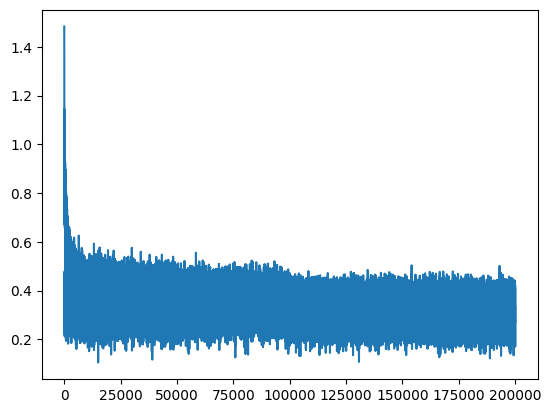

In [62]:
plt.plot(stepi, lossi)

In [63]:
### evaluating with train set

emb = C[Xtr] ## size [32, 3, 2]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) ## size [32, 100]
logits = h @ W2 + b2 ## size [32, 27]
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1022, grad_fn=<NllLossBackward0>)

In [64]:
### evaluating with dev set

emb = C[Xdev] ## size [32, 3, 2]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) ## size [32, 100]
logits = h @ W2 + b2 ## size [32, 27]
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1545, grad_fn=<NllLossBackward0>)

In [23]:
torch.randint(0, X.shape[0], (32,)) ## why X.shape[0] answer: this creates a range equivalent to 1st and last value in tensor x


tensor([219493,  94576, 168504,  56300, 163542, 137129, 100346,  64955, 190860,
        209738, 164060, 129090, 188389, 226601,  24463, 106506, 107024, 178748,
        181295, 103093, 220408,  22117,  23768, 196327,  29451, 147737, 194309,
        208219,   3609,  88925, 103309, 112179])

In [24]:
### splitting data into training, dev/validation and test
##80%, 10%, 10%
## training set is used to train parameters
## dev/validation is used to train hyperparameters
## test split is for evaluation performance of the model at the end

In [66]:
### sampling from the model
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
kayanniellend.
rylla.
emmastendraege.
zered.
elin.
shi.
jenne.
elisananar.
kayzion.
kalin.
shubergiaghiel.
kendreeller.
novana.
ura.
ted.
ryyah.
faeha.
kayjahe.
kyla.
